# String-to-String Similarity Problems and Algorithms

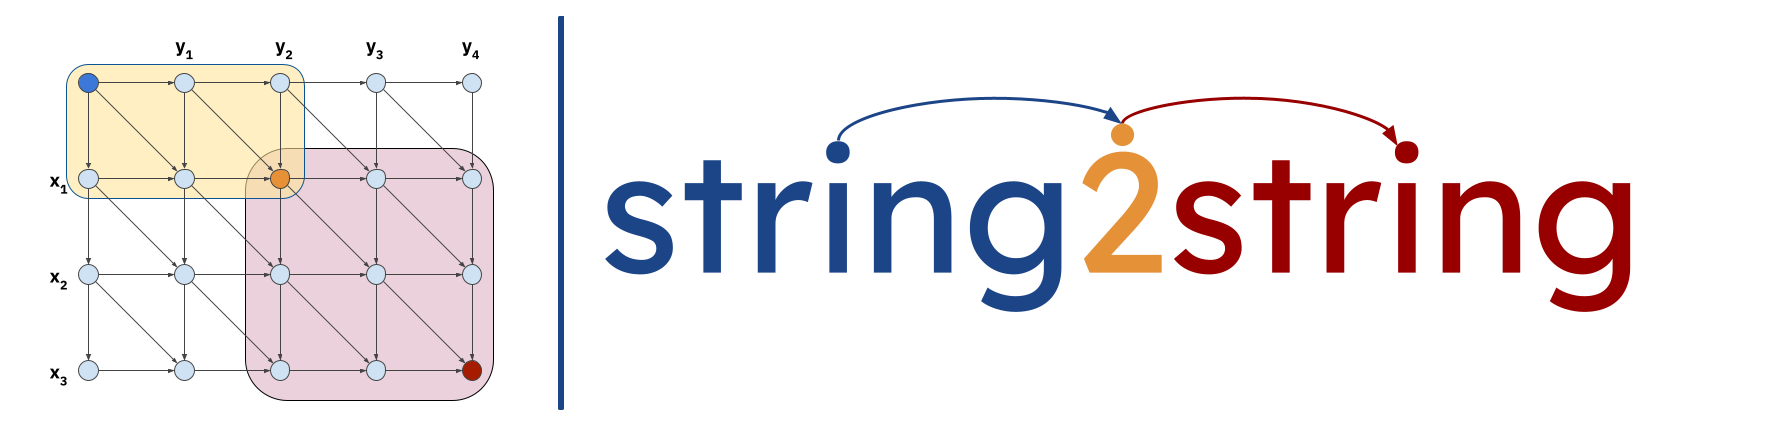

In [1]:
from IPython.display import Image
Image(filename='fables/string2string-logo.png')
# Image(url='https://raw.githubusercontent.com/stanfordnlp/string2string/main/fables/string2string-logo.png?token=GHSAT0AAAAAAB5KHQETSF3UOOWXYPJHECZAZAXW5HA')

This tutorial provides an introduction to the **similarity** module in the **string2string** package, and presents a few examples to showcase its usage. While it is not an exhaustive overview of the module, it offers insights into its key functionalities. For a more comprehensive understanding of the module, please consult the official documentation.

String similarity refers to the problem of measuring the degree to which two given strings are similar to each other based on a similarity function---which can be defined on various criteria, such as character matching, longest common substring or subsequence comparison, or structural alignment. There is a natural duality between string similarity measures and string distance measures, which means that it possible to convert one into the other with ease; hence, it is often the case that one uses string similarity and distance measures interchangeably.

The string2string package currently offers the following similarity algorithms:

* Cosine similarity
* BERTScore
* BARTScore
* Jaro similarity
* LCSubsequence similarity

Before we begin, please make sure that you have installed the string2string packag via *pip*.

In [2]:
# !pip install string2string

## Cosine Similarity

For two (non-zero) vectors, $x_1 \in \mathbb{R}^n$ and $x_2\in \mathbb{R}^n$ the **cosine similarity** between them is defined as follows:

$$
\begin{align*}
    \texttt{cosine-similarity}(x_1, x_2) & = ||x_1|| \ ||x_2|| \cos(\theta) \\
    & = \frac{x_1 \cdot x_2}{||x_1|| \ ||x_2||} \\
    & = \frac{\sum_{i=1}^n x_{1i} x_{2i}}{\sqrt{\sum_{i=1}^n x_{1i}^2} \sqrt{\sum_{i=1}^n x_{2i}^2}}
\end{align*}
$$

where $\theta$ denotes the angle between the vectors, $\cdot$ the dot product, and $|\cdot|$ the norm operator.

In practice, thought, we need to ensure that the denominator is nonzero; so, we often compute the cosine similarity as follows:

$$
\begin{align*}
    \texttt{cosine-similarity}(x_1, x_2) & = \frac{x_1 \cdot x_2}{\max(||x_1|| \ ||x_2||, \epsilon)}
\end{align*}
  $$              
where $\epsilon$ is a small value to avoid division by zero.


Let's now learn how to use the CosineSimilarity class in our library, which can automatically detect and handle both tensors and numpy arrays.


In [3]:
# Import relevant modules
import numpy as np
import torch

# Import the CosineSimilarity class from the similarity module
from string2string.similarity import CosineSimilarity

# Create an instance of the CosineSimilarity class
cosine_similarity = CosineSimilarity()

# Compute the cosine similarity between two tensors
result_tensor = cosine_similarity.compute(torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6]), dim=0)

# Compute the cosine similarity between two numpy arrays
result_np_array = cosine_similarity.compute(np.array([1, 2, 3]), np.array([4, 5, 6]), dim=0)

# Print the results, along with their types
print(f'Tensor result: {result_tensor} (type: {type(result_tensor)})')
print(f'Numpy array result: {result_np_array} (type: {type(result_np_array)})')

/Users/machine/opt/anaconda3/envs/string2string/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensor result: 0.9746317863464355 (type: <class 'torch.Tensor'>)
Numpy array result: 0.9746318461970762 (type: <class 'numpy.float64'>)


In the context of natural language processing, the cosine similarity can be used a quasi-metric to measure semantic similarity between the vector representations of two pieces of text.

Using the string2string library, we can do compute the cosine similarity between words using GloVe or fastText embeddings or between longer pieces of text, such as sentences, paragraphs, or even documents, via neural language models such as BERT.

In what follows, we will demonstrate how to compute the cosine similarity between difference pieces of text at the word and sentence levels.



### Cosine Similarity Between the Glove Embeddings of Pairs of Words

In [4]:
# Import the GloVeEmbeddings class from the misc module
from string2string.misc import GloVeEmbeddings

# Create an instance of the GloVeEmbeddings class
glove = GloVeEmbeddings(
    model='glove.6B.200d',
    dim=50,
    force_download=False,
    dir='/Users/machine/.cache/torch/hub/glove.6B.200d'
)

# Let's define a set of words
words = ['cat', 'dog', 'phone', 'computer']


embeds = []
# Compute the embeddings for each word
for word in words:
    embedding = glove.get_embedding(word)
    embeds.append(embedding)

# Create a matrix to store the cosine similarities
similarity_matrix = np.zeros((len(words), len(words)))
# Compute the cosine similarity between each pair of embeddings
for i in range(len(embeds)):
    similarity_matrix[i, i] = 1
    for j in range(i + 1, len(embeds)):
        result = cosine_similarity.compute(embeds[i], embeds[j], dim=1).item()
        similarity_matrix[i, j] = result
        similarity_matrix[j, i] = result
        print(f'The cosine similarity between the GloVe embeddings of "{words[i]}" and "{words[j]}" is {result:.2f}')


The cosine similarity between the GloVe embeddings of "cat" and "dog" is 0.92
The cosine similarity between the GloVe embeddings of "cat" and "phone" is 0.32
The cosine similarity between the GloVe embeddings of "cat" and "computer" is 0.35
The cosine similarity between the GloVe embeddings of "dog" and "phone" is 0.36
The cosine similarity between the GloVe embeddings of "dog" and "computer" is 0.33
The cosine similarity between the GloVe embeddings of "phone" and "computer" is 0.72


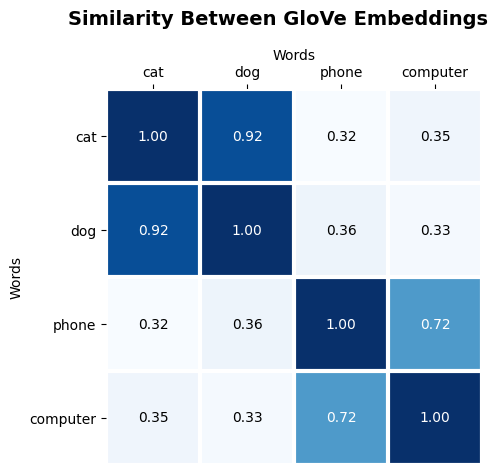

In [5]:
# We can also visualize the cosine similarity scores using a heatmap

from string2string.misc.plotting_functions import plot_heatmap

plot_heatmap(
    similarity_matrix, 
    title='Similarity Between GloVe Embeddings',
    x_ticks = words,
    y_ticks = words,
    x_label = 'Words',
    y_label = 'Words',
    valfmt = '{x:.2f}',
    cmap="Blues",
    )

In [6]:
# Note about their similarity. / can also do this using fastText embeddings.

### Cosine Similarity Between the Language Model Embeddings of Pairs of Sentences

In [7]:
# Import the ModelEmbeddings class from the misc module
from string2string.misc import ModelEmbeddings

# Create an instance of the ModelEmbeddings class (if device is not specified, it will be automatically detected)
bart_model = ModelEmbeddings(
    model_name_or_path='facebook/bart-large'
)

# Let's define a set of sentences
sentences = [
    'Tea is my favorite drink to have in the morning. As Arthur Wing Pinero said, where there is tea there is hope.',
    'Richard Feynman, the famous physicist, made significant contributions to the field of quantum electrodynamics.',
    'Coffee is one of the most celebrated beverages in the world. It is a brewed drink prepared from roasted coffee beans.',
    'Albert Einstein published four groundbreaking papers in 1905, which laid the foundation for his theory of relativity.',
]

# Compute the sentence embeddings for each sentence
embeds = []
for sentence in sentences:
    embedding = bart_model.get_embeddings(sentence, embedding_type='mean_pooling')
    embeds.append(embedding)

In [8]:
# Let's print each sentence
for i, sentence in enumerate(sentences):
    print(f'Sentence {i + 1}: {sentence}')

Sentence 1: Tea is my favorite drink to have in the morning. As Arthur Wing Pinero said, where there is tea there is hope.
Sentence 2: Richard Feynman, the famous physicist, made significant contributions to the field of quantum electrodynamics.
Sentence 3: Coffee is one of the most celebrated beverages in the world. It is a brewed drink prepared from roasted coffee beans.
Sentence 4: Albert Einstein published four groundbreaking papers in 1905, which laid the foundation for his theory of relativity.


In [9]:
# Let's create a matrix to store the cosine similarity scores
similarity_matrix = np.zeros((len(sentences), len(sentences)))

# Compute the cosine similarity between each pair of embeddings
for i in range(len(embeds)):
    similarity_matrix[i, i] = 1
    for j in range(i + 1, len(embeds)):
        result = cosine_similarity.compute(embeds[i], embeds[j], dim=1).item()
        similarity_matrix[i, j] = result
        similarity_matrix[j, i] = result
        print(f'The cosine similarity between the BART embeddings of Sentence {i + 1} and Sentence {j + 1} is {result:.2f}')


The cosine similarity between the BART embeddings of Sentence 1 and Sentence 2 is 0.52
The cosine similarity between the BART embeddings of Sentence 1 and Sentence 3 is 0.73
The cosine similarity between the BART embeddings of Sentence 1 and Sentence 4 is 0.55
The cosine similarity between the BART embeddings of Sentence 2 and Sentence 3 is 0.53
The cosine similarity between the BART embeddings of Sentence 2 and Sentence 4 is 0.80
The cosine similarity between the BART embeddings of Sentence 3 and Sentence 4 is 0.53


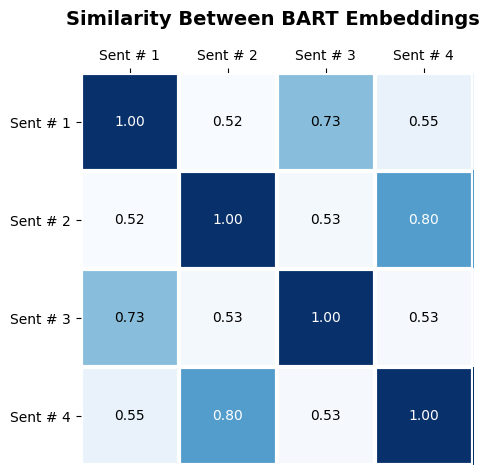

In [10]:
# We can also visualize the cosine similarity scores using a heatmap

x_ticks = [f'Sent # {i + 1}' for i in range(len(sentences))]

from string2string.misc.plotting_functions import plot_heatmap

plot_heatmap(
    similarity_matrix, 
    title='Similarity Between BART Embeddings',
    x_ticks = x_ticks,
    y_ticks = x_ticks,
    x_label = '',
    y_label = '',
    valfmt = '{x:.2f}',
    cmap="Blues",
    )

### BERTScore and BARTScore for Semantic Similarity

In [11]:
# Import the BERTScore and BARTScore classes from the misc module
from string2string.similarity import BERTScore, BARTScore

# Create an instance of the BERTScore class
bert_score = BERTScore(
    model_name_or_path='bert-base-uncased',
)

# Create an instance of the BARTScore class (if device is not specified, it will be automatically detected)
bart_score = BARTScore(
    model_name_or_path='facebook/bart-large-cnn',
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# Let's define a set of sentences -- source sentences and target sentences -- in the following format
# source_sentences = [s1, s1, s1, s1, s2, s2, s2, s2, s3, s3, s3, s3, s4, s4, s4, s4]
# target_sentences = [s1, s2, s3, s4, s1, s2, s3, s4, s1, s2, s3, s4, s1, s2, s3, s4]
source_sentences = []
target_sentences = []
for i in range(len(sentences)):
    for j in range(len(sentences)):
        source_sentences.append(sentences[i])
        target_sentences.append(sentences[j])

#### BERTScore

In [36]:
# Compute the BERTScore similarity scores
bertscore_similarity_scores = bert_score.compute(
    source_sentences,
    target_sentences,
)

# Get the precision scores
bertscore_precision_scores = bertscore_similarity_scores['precision'].reshape(len(sentences), len(sentences))

# Print the BERTScore similarity scores (rounded to 2 decimal places)
print(f'BERTScore similarity scores (precision):')
print(np.round(bertscore_precision_scores, 2))

BERTScore similarity scores (precision):
[[1.   0.34 0.44 0.35]
 [0.33 1.   0.37 0.55]
 [0.52 0.39 1.   0.4 ]
 [0.37 0.59 0.41 1.  ]]


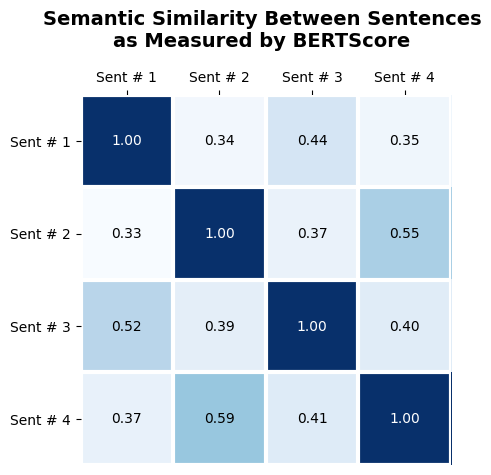

In [53]:
# We can also visualize the BERTScore similarity scores using a heatmap
plot_heatmap(
    bertscore_precision_scores,
    title='Semantic Similarity Between Sentences\nas Measured by BERTScore',
    x_ticks = x_ticks,
    y_ticks = x_ticks,
    x_label = '',
    y_label = '',
    valfmt = '{x:.2f}',
    cmap="Blues",
)

#### BARTScore

In [45]:
# Compute the BARTScore similarity scores
bartscore_similarity_scores = bart_score.compute(
    source_sentences,
    target_sentences,
)

# Get the BARTScore scores
bartscore_scores = bartscore_similarity_scores['score'].reshape(len(sentences), len(sentences))

# Print the BERTScore similarity scores (rounded to 2 decimal places)
print(f'BARTScore similarity scores:')
print(np.round(bartscore_scores, 2))

BARTScore similarity scores:
[[-0.24 -3.28 -2.87 -3.51]
 [-4.11 -0.27 -3.09 -2.94]
 [-3.76 -3.32 -0.27 -3.49]
 [-3.94 -2.27 -3.12 -0.35]]


We can also visualize the BERTScore similarity scores using a heatmap

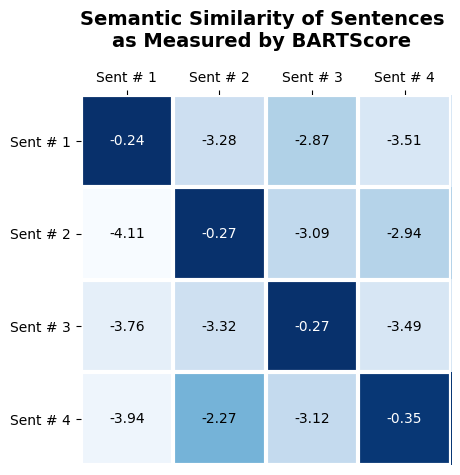

In [55]:
plot_heatmap(
    bartscore_scores,
    title='Semantic Similarity of Sentences\nas Measured by BARTScore',
    x_ticks = x_ticks,
    y_ticks = x_ticks,
    x_label = '',
    y_label = '',
    valfmt = '{x:.2f}',
    cmap="Blues",
)

## Jaro Similarity

The Jaro similarity is a string similarity metric that measures the similarity between two strings. 

It is defined as follows:

$$
\begin{align}
\texttt{Jaro-Similarity}(s_1, s_2) &= 
    \begin{cases}
        0 & \text{ if } \texttt{matches} = 0 \\
        \frac{1}{3} \left( \frac{m}{|s_1|} + \frac{\texttt{matches}}{|s_2|} + \frac{\texttt{matches} - \texttt{transpositions}}{\texttt{matches}} \right) & \text{otherwise}
    \end{cases}
\end{align}
$$

where $s_1$ and $s_2$ are two strings, $\texttt{matches}$ denotes the number of "Jaro-matching" characters between $s_1$ and $s_2$ and $\texttt{transpositions}$ the number of "Jaro-transpositions" between $s_1$ and $s_2$.

* A character from $s_1$ is a "Jaro-matching" character with a character from $s_2$ if the characters are the same and the distance between the two characters is less than or equal to the floor of $\frac{1}{2} \max(|s_1|, |s_2|)$.
* A "Jaro-transposition" occurs when two characters from $s_1$ and $s_2$ are "Jaro-matching" but are not in the right order in their respective strings (i.e., the characters are transposed). 

For more details, please refer to the Wikipedia page of [Jaro-Winkler distance](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance).


In [61]:
# Let's import the Jaro similarity class from the similarity module
from string2string.similarity import JaroSimilarity

# Create an instance of the JaroSimilarity class
jaro_similarity = JaroSimilarity()

# Compute the Jaro similarity scores of the following pairs of words
score = jaro_similarity.compute('FARMVILLE', 'FAREMVIEL')
print(f'The Jaro similarity score between FARMVILLE and FAREMVIEL is {score:.2f}')


The Jaro similarity score between FARMVILLE and FAREMVIEL is 0.88


In [65]:
# https://en.wikipedia.org/wiki/To_be,_or_not_to_be#Second_Quarto_(1604)
second_quarto = r"""To be, or not to be, that is the question,
Whether 'tis nobler in the mind to suffer
The slings and arrows of outragious fortune,
Or to take Arms against a sea of troubles,
And by opposing, end them, to die to sleep
No more, and by a sleep, to say we end
The heart-ache, and the thousand natural shocks
That flesh is heir too; tis a consumation
Devoutly to be wish'd to die to sleep,
To sleep, perhance to dream, ay, there's the rub,
For in that sleep of death what dreams may come
When we haue shuffled off this mortal coil
Muſt giue vs pauſe, there's the reſpect
That makes calamitie of ſo long life:
For who would beare the whips and ſcorns of time,
Th'oppreſſors wrong, the proude mans contumly,
The pangs of deſpiz'd loue, the lawes delay,
The inſolence of office, and the ſpurnes
That patient merrit of the'vnworthy takes,
When he himſelfe might his quietas make
With a bare bodkin; who would fardels beare,
To grunt and ſweat vnder a wearie life,
But that the dread of ſomething after death,
The vndiſcouer'd country, from whose borne
No trauiler returnes, puzzels the will,
And makes vs rather beare thoſe ills we haue,
Then flie to others we know not of.
Thus conſcience dooes make cowards,
And thus the natiue hiew of reſolution
Is ſickled ore with the pale caſt of thought,
And enterpriſes of great pitch and moment,
With this regard theyr currents turne awry,
And loose the name of action. Soft you now,
The faire Ophelia, Nimph in thy orizons
Be all my ſinnes remembred.
"""

# https://en.wikipedia.org/wiki/To_be,_or_not_to_be#First_Folio_(1623)
first_folio = r"""To be, or not to be, that is the Question:
Whether ’tis Nobler in the mind to suffer
The Slings and Arrows of outragious Fortune,
Or to take Armes against a Sea of troubles,
And by opposing end them: to dye, to sleep
No more; and by a sleep, to say we end
The Heart-ake, and the thouſand Naturall ſhockes
That Flesh is heyre too? 'Tis a consummation
Deuoutly to be wiſh'd. To dye to sleepe,
To sleep, perchance to Dream; I, there's the rub,
For in that sleep of death, what dreams may come,
When we haue ſhufflel’d off this mortall coile,
Muſt giue us pause. There's the respect
That makes Calamity of long life:
For who would beare the Whips and Scornes of time,
The Oppreſſors wrong, the poore mans Contumely,
The pangs of diſpriz’d Loue, the Lawes delay,
The inſolence of Office, and the Spurnes
That patient merit of the unworthy takes,
When he himſelfe might his Quietus make
With a bare Bodkin? Who would theſe Fardles beare
To grunt and ſweat vnder a weary life,
But that the dread of ſomething after death,
The vndiſcouered Countrey, from whoſe Borne
No Traueller returnes, Puzels the will,
And makes vs rather beare those illes we haue,
Then flye to others that we know not of.
Thus Conſcience does make Cowards of vs all,
And thus the Natiue hew of Resolution
Is ſicklied o’re, with the pale caſt of Thought,
And enterprizes of great pith and moment,
With this regard their Currants turne away,
And looſe the name of Action. Soft you now,
The faire Ophelia? Nimph, in thy Orizons
Be all my ſinnes remembred.
"""

# Let's first tokenize the texts
from string2string.misc import Tokenizer
tokenizer = Tokenizer(word_delimiter=' ')

# Tokenize the texts
second_quarto_tokens = tokenizer.tokenize(second_quarto)
first_folio_tokens = tokenizer.tokenize(first_folio)

# Compute the Jaro similarity scores of the two versions of Hamlet at the word level
jaro_similarity_hamlet_word_level = jaro_similarity.compute(second_quarto_tokens, first_folio_tokens)

# Compute the Jaro similarity scores of the two versions of Hamlet at the character level
jaro_similarity_hamlet_character_level = jaro_similarity.compute(second_quarto, first_folio)

# Print the Jaro similarity scores (rounded to 2 decimal places)
print(f'The Jaro similarity scores between the two versions of Hamlet at the word level is {jaro_similarity_hamlet_word_level:.2f}')
print(f'The Jaro similarity scores between the two versions of Hamlet at the character level is {jaro_similarity_hamlet_character_level:.2f}')


The Jaro similarity scores between the two versions of Hamlet at the word level is 0.66
The Jaro similarity scores between the two versions of Hamlet at the character level is 0.82


>  With this example, we have reached the end of the alignment tutorial. We hope that you have found it useful. If you have any questions or suggestions, please feel free to contact us.

##### $\square$ Q.E.D.